## Simulation of Murdock and Okada (1970)
We start by comparing how our prototype- and instance-based implementations of CMR account for behavior in a classic experiment where each item is presented just once per study phase. For these simulations, we used the dataset reported by @murdock1970interresponse. Each of 72 undergraduates performed 20 trials with study lists each consisting of 20 unique words visually presented at either 60 or 120 words per minute. Given a particular subject, words were unique both within and across trials, and randomly selected from the Toronto Word Pool [@friendly1982toronto], a widely-used collection of high frequency nouns, adjectives, and verbs.

While the major focus of the original report by @murdock1970interresponse was to investigate inter-response times in single-trial free recall, here we focus consideration on the content of recorded recall sequences. Because it excludes within-list repetitions of studied items, this dataset presents the opportunity to compare model performance under simplified conditions. Since items' feature representations are assumed orthogonal under considered variants of CMR, retrieving a pattern of contextual associations given an item-based cue only requires abstraction over the cued item's pre-experimental and single experimental contextual associations. Interpretation of apparent differences in performance across model variants thus focus primarily on mechanisms for context-based item representation retrieval.

In [9]:
#| code-summary: code -- load dependencies and data

from compmemlearn.fitting import murdock_objective_function, apply_and_concatenate
from compmemlearn.models import Classic_CMR, Instance_CMR
from compmemlearn.models import Trace_Reinstatement_CMR
from compmemlearn.datasets import prepare_murdock1970_data, simulate_data
from scipy.optimize import differential_evolution
from numba.typed import List, Dict
from numba.core import types
from numba import njit
from psifr import fr
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

murd_trials0, murd_events0, murd_length0 = prepare_murdock1970_data('../../../data/mo1970.txt')

We compared the original prototype-based implementation of CMR against our novel instance-based implementation. First we evaluated each model variant based on their ability to predict the specific sequences of recalls exhibited by each participant. Considering all 20 trials performed by each participant in the dataset, we applied the differential evolution optimization technique to find for each model the parameter configuration that maximized the likelihood of recorded recall sequences. We obtained a unique optimal parameter configuration for each unique participant and each considered model variant. To measure the goodness-of-fit for each parameter configuration and corresponding model, [Figure @fig-MurdOkaFits] plots the log-likelihood of each participant's recall sequences given each model variant's corresponding optimized parameter configuration. The distribution of log-likelihood scores between participants for the PrototypeCMR and InstanceCMR model variants only marginally differ, suggesting little meaningful difference between variants in their effectiveness accounting for participant recall performance across the dataset.

In [2]:
#| output: false
#| code-summary: code -- 1) fit PrototypeCMR participant-by-participant

cmr_free_parameters = (
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity',
    'delay_drift_rate'
)

lb = np.finfo(float).eps
ub = 1-np.finfo(float).eps

cmr_bounds = [
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10),
    (lb, ub),
]

# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model
@njit(fastmath=True, nogil=True)
def init_cmr(item_count, presentation_count, parameters):
    return Classic_CMR(item_count, presentation_count, parameters)

subject_trial_count = 20 # Each subject gets 20 trials/lists a piece.
cmr_results = []

for subject, start_index in enumerate(range(0, len(murd_trials0), subject_trial_count)):
    print(subject, start_index)

    # cost function to be minimized
    # ours scales inversely with the probability that the data could have been 
    # generated using the specified parameters and our model
    cost_function = murdock_objective_function(
        List([murd_trials0[start_index:start_index+subject_trial_count]]), 
        List([murd_length0]),
        init_cmr,
        {'sampling_rule': 0, 'mfc_familiarity_scale': 0, 
         'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0}, 
        cmr_free_parameters)

    cmr_results.append(differential_evolution(cost_function, cmr_bounds, disp=False))
    print(cmr_results[-1].fun)

0 0
290.1696909772668
1 20
240.21091650426135
2 40
330.3343148621522
3 60
343.7018033562105
4 80
328.2348088908294
5 100
304.50689420838086
6 120
262.5010131079227
7 140
287.9876722136334
8 160
232.88863083775556
9 180
349.83784509503226
10 200
184.76488756186305
11 220
314.9691333677882
12 240
366.169076372925
13 260
268.4946431082745
14 280
285.3692072453269
15 300
335.2504715327692
16 320
310.89436874811696
17 340
285.75484911144804
18 360
392.29362371858696
19 380
390.67932942739543
20 400
312.83215807610105
21 420
317.9947589555959
22 440
384.8860957316117
23 460
297.73917849330866
24 480
268.7265413715306
25 500
368.2578041450569
26 520
327.5010807841885
27 540
289.9449794046736
28 560
346.9778369428562
29 580
297.68180388432637
30 600
335.739002466553
31 620
301.52195066369194
32 640
333.696870668408
33 660
377.31913178024325
34 680
309.5996144339117
35 700
386.36139124727697
36 720
292.25687577362226
37 740
295.5646326056151
38 760
237.7315090452987
39 780
233.9118402490054
40 

In [15]:
#| output: false
#| code-summary: code -- 2) fit InstanceCMR participant-by-participant

icmr_free_parameters = (
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
#    'choice_sensitivity',
    'context_sensitivity',
#    'feature_sensitivity'
    'delay_drift_rate',
)

icmr_bounds = [
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10),
#    (lb, 10),
#    (lb, 10)
    (lb, ub),
]

# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model
@njit(fastmath=True, nogil=True)
def init_icmr(item_count, presentation_count, parameters):
    return Trace_Reinstatement_CMR(item_count, presentation_count, parameters)

subject_trial_count = 20 # Each subject gets 20 trials/lists a piece.
icmr_results = []

for subject, start_index in enumerate(range(0, len(murd_trials0), subject_trial_count)):
    print(subject, start_index)

    # cost function to be minimized
    # ours scales inversely with the probability that the data could have been 
    # generated using the specified parameters and our model
    cost_function = murdock_objective_function(
    List([murd_trials0[start_index:start_index+subject_trial_count]]),  
    List([murd_length0]),
    init_icmr,
    {'choice_sensitivity': 1, 'feature_sensitivity': 1, 'context_reinstatement': 7}, 
    icmr_free_parameters)

    icmr_results.append(differential_evolution(cost_function, icmr_bounds, disp=False))
    print(icmr_results[-1].fun)

0 0
326.47881748290865
1 20
235.1598655038706
2 40
325.3032219073434
3 60
340.8302174798453
4 80
425.63839871222655
5 100
319.1329193934613
6 120
257.23290954476124
7 140
313.053134436889
8 160
299.10413177718334
9 180
351.18562298313896
10 200
180.04029595335794
11 220
406.3191735586555
12 240
354.76006871763536
13 260
286.21439291952805
14 280
287.24978991193325
15 300
426.81875576398045
16 320
432.3247001018176
17 340
289.57569159536064
18 360
388.07440278200255
19 380
485.0898449475034
20 400
428.8204850877388
21 420
315.10276518689363
22 440
470.4533860973527
23 460
294.9429139964931
24 480
266.7051827858752
25 500
368.15295070946104
26 520
437.44858572130414
27 540
289.03666434794377
28 560
346.97299015639396
29 580
303.5034803572292
30 600
377.4890896144161
31 620
305.75547257403747
32 640
367.1805260908368
33 660
447.8316136447576
34 680
310.97224279802856
35 700
386.9467835980994
36 720
292.8633271532225
37 740
296.12173093621
38 760
264.48051592348065
39 780
233.1743003634147

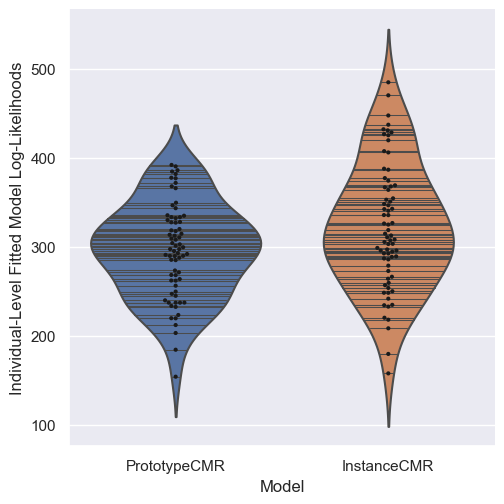

In [16]:
#| code-summary: code -- 3) plot distribution of log-likelihoods across individual subjects
plt.style.use('default')

individual_fits = [result.fun for result in cmr_results] + [result.fun for result in icmr_results]
labels = ['PrototypeCMR'] * len(cmr_results) + ['InstanceCMR'] * len(icmr_results)
individual_df = pd.DataFrame(individual_fits, index=labels, columns=['Fit']).reset_index()
individual_df.columns = ['Model', 'Fit']

sns.set(style="darkgrid")

g = sns.catplot(x='Model', y='Fit', data=individual_df, kind='violin', inner='stick')
sns.swarmplot(x="Model", y="Fit", color="k", size=3, data=individual_df, ax=g.ax)
g.ax.set_ylabel('Individual-Level Fitted Model Log-Likelihoods');
#plt.savefig('individual_murdock1970.pdf', bbox_inches="tight")

summary_table = pd.DataFrame(group.describe().rename(columns={'Fit':name}).squeeze()
            for name, group in individual_df.groupby('Model')).T.to_markdown()

In [17]:
#| output: false
print(summary_table)

|       |   InstanceCMR |   PrototypeCMR |
|:------|--------------:|---------------:|
| count |       72      |        72      |
| mean  |      322.094  |       295.905  |
| std   |       70.0144 |        52.7631 |
| min   |      158.18   |       154.477  |
| 25%   |      277.693  |       260.948  |
| 50%   |      312.013  |       297.71   |
| 75%   |      367.424  |       330.893  |
| max   |      485.09   |       392.294  |


As a follow-up, we also compared how readily each model could account for organizational summary statistics in the dataset. We found for each model variant the optimal parameter configuration maximizing the likelihood of the entire dataset rather than participant-by-participant. Using each fitted model variant, we simulated 1000 unique free recall trials and measured summary statistics from the result. [Figure @fig-MurdOkaSummary] plots for each model against the corresponding statistics collected over the dataset how recall probability varies as a function of serial position, how the probability of recalling an item first varies as a function of serial position, and how the conditional recall probabability of an item varies as a function of its serial lag from the previously recalled item. Recapitulating our comparison of log-likelihood distributions fitted over discrete participants, we found that both our prototype-based and instance-based CMR implementations account for these benchmark organizational summary statistics across the full dataset to similar extents. To build on this finding of broad model equivalence with respect to the results reported by @murdock1970interresponse, we consider the model variants under broader experimental conditions.

In [6]:
#| output: false
#| code-summary: code -- 1) fit CMR to entire dataset rather than participant-by-participant

cost_function = murdock_objective_function(
    List([murd_trials0]),  
    List([murd_length0]),
    init_cmr,
    {'sampling_rule': 0, 'mfc_familiarity_scale': 0, 
     'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0}, 
    cmr_free_parameters)

cmr_result = differential_evolution(cost_function, cmr_bounds, disp=True)

differential_evolution step 1: f(x)= 28932.6
differential_evolution step 2: f(x)= 28932.6
differential_evolution step 3: f(x)= 26153.1
differential_evolution step 4: f(x)= 26153.1
differential_evolution step 5: f(x)= 25369
differential_evolution step 6: f(x)= 25300.6
differential_evolution step 7: f(x)= 25300.6
differential_evolution step 8: f(x)= 25300.6
differential_evolution step 9: f(x)= 25300.6
differential_evolution step 10: f(x)= 24218.7
differential_evolution step 11: f(x)= 24218.7
differential_evolution step 12: f(x)= 24218.7
differential_evolution step 13: f(x)= 24073.9
differential_evolution step 14: f(x)= 24073.9
differential_evolution step 15: f(x)= 24004
differential_evolution step 16: f(x)= 24004
differential_evolution step 17: f(x)= 23561.2
differential_evolution step 18: f(x)= 23284.8
differential_evolution step 19: f(x)= 23284.8
differential_evolution step 20: f(x)= 23284.8
differential_evolution step 21: f(x)= 23284.8
differential_evolution step 22: f(x)= 23281.6
dif

In [7]:
#| include: false
print(cmr_result)

     fun: 22625.64131059873
     jac: array([ 1.49593688e+00,  1.31367415e+00, -1.98087945e+00,  1.05355866e+00,
       -2.72277246e+01, -3.19487299e+00, -6.54836131e-03,  2.73939806e-01,
        2.45927367e+00,  4.32919478e-02,  1.04882930e+00,  7.93443174e-01])
 message: 'Optimization terminated successfully.'
    nfev: 10715
     nit: 43
 success: True
       x: array([5.35009134e-01, 2.73529517e-03, 7.08417254e-01, 4.29751065e-01,
       1.00000000e+00, 8.57713188e-02, 1.00520846e+01, 2.47340408e+00,
       3.13951468e-02, 3.36717195e-01, 6.29747315e+00, 9.94265537e-01])


In [8]:
#| output: false
#| code-summary: code -- 2) fit Instance_CMR to entire dataset rather than participant-by-participant

cost_function = murdock_objective_function(
    List([murd_trials0]),  
    List([murd_length0]),
    init_icmr,
    {'choice_sensitivity': 1, 'feature_sensitivity': 1}, 
    icmr_free_parameters)

icmr_result = differential_evolution(cost_function, icmr_bounds, disp=True)

SystemError: CPUDispatcher(<function murdock_data_likelihood at 0x0000020CF8184EE0>) returned a result with an error set

In [ ]:
#| include: false
print(icmr_result)

     fun: 22687.62345968608
     jac: array([ -2.2304448 ,   4.77521098,  -0.86729414,  -2.94057827,
       -15.73353067,   0.52896212,   0.02000888,   0.        ,
        14.51917342,  11.90601325,  -0.57916623, -13.61986499,
        -3.32656755])
 message: 'Optimization terminated successfully.'
    nfev: 12015
     nit: 24
 success: True
       x: array([6.49116610e-01, 4.45405447e-03, 7.68446980e-01, 7.63169921e-03,
       1.00000000e+00, 2.93379645e-01, 1.02770225e+01, 4.52131220e+01,
       3.13194288e-02, 3.37018745e-01, 1.86906517e+00, 9.97048917e-01,
       1.00000000e+01])


In [ ]:
#| output: false
#| code-summary: code -- 3) compose simulated spc, lag-crp, pfr from overall fitting results

fitted_parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
for i in range(len(cmr_result.x)):
    fitted_parameters[cmr_free_parameters[i]] = cmr_result.x[i]
fitted_parameters['sampling_rule'] = 0
fitted_parameters['mfc_familiarity_scale'] = 0
fitted_parameters['mcf_familiarity_scale'] = 0
fitted_parameters['drift_familiarity_scale'] = 0

model = Classic_CMR(murd_length0, murd_length0, fitted_parameters)

sim_df = simulate_data(model, 1000)
true_df = murd_events0.copy()

cmr_spc = apply_and_concatenate(fr.spc, sim_df, true_df, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_lag_crp = apply_and_concatenate(fr.lag_crp, sim_df, true_df, 'source', ['PrototypeCMR', 'data'])
cmr_pfr = apply_and_concatenate(fr.pnr, sim_df, true_df, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_pfr = cmr_pfr.query('output <= 1')

fitted_parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
for i in range(len(icmr_result.x)):
    fitted_parameters[icmr_free_parameters[i]] = icmr_result.x[i]
fitted_parameters['sampling_rule'] = 0
fitted_parameters['choice_sensitivity'] = 1
fitted_parameters['feature_sensitivity'] = 1

model = init_icmr(murd_length0, murd_length0, fitted_parameters)

sim_df = simulate_data(model, 1000)
icmr_spc = apply_and_concatenate(fr.spc, sim_df, true_df, contrast_name='source', labels=['InstanceCMR', 'data'])
icmr_lag_crp = apply_and_concatenate(fr.lag_crp, sim_df, true_df, 'source', ['InstanceCMR', 'data'])
icmr_pfr = apply_and_concatenate(fr.pnr, sim_df, true_df, contrast_name='source', labels=['InstanceCMR', 'data'])
icmr_pfr = icmr_pfr.query('output <= 1')

In [ ]:
#| code-summary: code -- 4) plot each summary statistic corresponding to each configured model

import matplotlib.pyplot as plt

sns.set(style='darkgrid')

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 15/2), sharey=False)

# serial position curve
sns.lineplot(ax=axes[0, 0], data=icmr_spc, x='input', y='recall', err_style='bars', hue='source', legend=False)
axes[0, 0].set(xlabel='Study Position', ylabel='Recall Rate')
axes[0, 0].set_xticks(np.arange(1, 21, 2))
axes[0, 0].set_ylim((0, 1))

sns.lineplot(ax=axes[1, 0], data=cmr_spc, x='input', y='recall', err_style='bars', hue='source', legend=False)
axes[1, 0].set(xlabel='Study Position', ylabel='Recall Rate')
axes[1, 0].set_xticks(np.arange(1, 21, 2))
axes[1, 0].set_ylim((0, 1))

# lag crp curve
max_lag = 5
filt_neg = f'{-max_lag} <= lag < 0'
filt_pos = f'0 < lag <= {max_lag}'

sns.lineplot(ax=axes[0, 1], data=icmr_lag_crp.query(filt_neg), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
sns.lineplot(ax=axes[0, 1], data=icmr_lag_crp.query(filt_pos), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
axes[0, 1].set(xlabel='Item\'s Lag In Study List From Last Recalled Item', ylabel='Conditional Recall Rate')
axes[0, 1].set_xticks(np.arange(-5, 6, 1))
axes[0, 1].set_ylim((0, 1))

sns.lineplot(ax=axes[1, 1], data=cmr_lag_crp.query(filt_neg), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
sns.lineplot(ax=axes[1, 1], data=cmr_lag_crp.query(filt_pos), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
axes[1, 1].set(xlabel='Item\'s Lag In Study List From Last Recalled Item', ylabel='Conditional Recall Rate')
axes[1, 1].set_xticks(np.arange(-5, 6, 1))
axes[1, 1].set_ylim((0, 1))

# pfr
sns.lineplot(data=icmr_pfr, x='input', y='prob', err_style='bars', ax=axes[0, 2], hue='source')
axes[0, 2].set(xlabel='Study Position', ylabel='Probability of First Recall')
axes[0, 2].set_xticks(np.arange(1, 21, 2))
axes[0, 2].set_ylim((0, 1))

sns.lineplot(data=cmr_pfr, x='input', y='prob', err_style='bars', ax=axes[1, 2], hue='source')
axes[1, 2].set(xlabel='Study Position', ylabel='Probability of First Recall')
axes[1, 2].set_xticks(np.arange(1, 21, 2))
axes[1, 2].set_ylim((0, 1))

# set legend of axis 2 outside the plot, to the right
axes[0, 2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes[1, 2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.tight_layout(pad=3)
plt.savefig('overall_murdock1970.pdf', bbox_inches='tight')

NameError: name 'sns' is not defined

![Comparison of summary statistics between each model against observed data [@murdock1970interresponse]](overall_murdock1970.pdf){#fig-murdokasummary}